### Import

In [1]:
import sys
sys.path.insert(0, '../Src/')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.losses import CategoricalCrossentropy
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2, l1
from keras.metrics import Accuracy, SparseCategoricalAccuracy, CategoricalAccuracy, AUC, \
    PrecisionAtRecall, Recall, Precision, F1Score

from Model_maintenance import modelMaintenance

### Load data

Load dataframe

In [21]:
df_train = pd.read_csv('..\data\predictive_maintenance_train_resampled.csv')
df_test = pd.read_csv('..\data\predictive_maintenance_test_resampled.csv')
df_val = pd.read_csv('..\data\predictive_maintenance_validation.csv')

Extract the name of variable of 'Target'

In [4]:
name_target_col = list(filter(lambda ligne: 'Failure' in ligne, df_train.columns))
name_target_col

['Heat Dissipation Failure',
 'No Failure',
 'Overstrain Failure',
 'Power Failure',
 'Tool Wear Failure']

Split to train and test data
Separation of explanatory variables and variables to identify

In [22]:
X_train = df_train.drop(columns=name_target_col)
y_train = df_train[name_target_col]
X_test = df_test.drop(columns=name_target_col)
y_test = df_test[name_target_col]
X_val = df_val.drop(columns=name_target_col)
y_val = df_val[name_target_col]

In [6]:
num_features = X_train.shape[1] # Nombre de variables explicatives
num_target = y_train.shape[1]   # Nombre de variables cibles

In [28]:

keras.backend.clear_session()


### Create model

In [29]:


model = modelMaintenance(
    num_layers=5, 
    num_input=num_features, 
    num_output=num_target,
    loss=CategoricalCrossentropy(),
    optimizer='adam',#Adam(5e-4),
    metrics=[CategoricalAccuracy(), AUC(),  Precision(), Recall()])#, Precision(), Recall(), F1Score()])

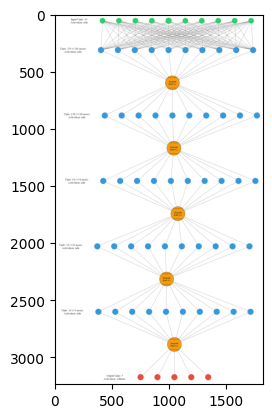

In [30]:
model.plot_model()

### Training Model

In [31]:
model.train(X_train.to_numpy(), y_train.to_numpy(), X_test.to_numpy(), y_test.to_numpy(), batch_size=256, epochs=100, verbose=1)

Epoch 1/100
121/121 [==============================] - 10s 82ms/step - loss: 0.7876 - categorical_accuracy: 0.7015 - auc: 0.9248 - precision: 0.8696 - recall: 0.5479 - val_loss: 0.2496 - val_categorical_accuracy: 0.9244 - val_auc: 0.9895 - val_precision: 0.9296 - val_recall: 0.9205 - lr: 0.0010
Epoch 2/100
  2/121 [..............................] - ETA: 7s - loss: 0.3882 - categorical_accuracy: 0.8906 - auc: 0.9783 - precision: 0.9037 - recall: 0.8613

c:\Users\yanni\anaconda3\envs\Predictive_maintenance_project\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


121/121 [==============================] - 10s 83ms/step - loss: 0.2470 - categorical_accuracy: 0.9294 - auc: 0.9900 - precision: 0.9429 - recall: 0.9117 - val_loss: 0.2096 - val_categorical_accuracy: 0.9431 - val_auc: 0.9910 - val_precision: 0.9440 - val_recall: 0.9413 - lr: 0.0010
Epoch 3/100
121/121 [==============================] - 10s 83ms/step - loss: 0.1625 - categorical_accuracy: 0.9579 - auc: 0.9943 - precision: 0.9642 - recall: 0.9506 - val_loss: 0.1907 - val_categorical_accuracy: 0.9515 - val_auc: 0.9914 - val_precision: 0.9528 - val_recall: 0.9506 - lr: 0.0010
Epoch 4/100
121/121 [==============================] - 10s 84ms/step - loss: 0.1306 - categorical_accuracy: 0.9681 - auc: 0.9956 - precision: 0.9713 - recall: 0.9624 - val_loss: 0.2779 - val_categorical_accuracy: 0.9209 - val_auc: 0.9884 - val_precision: 0.9223 - val_recall: 0.9199 - lr: 0.0010
Epoch 5/100
121/121 [==============================] - 10s 85ms/step - loss: 0.1119 - categorical_accuracy: 0.9725 - auc: 0.

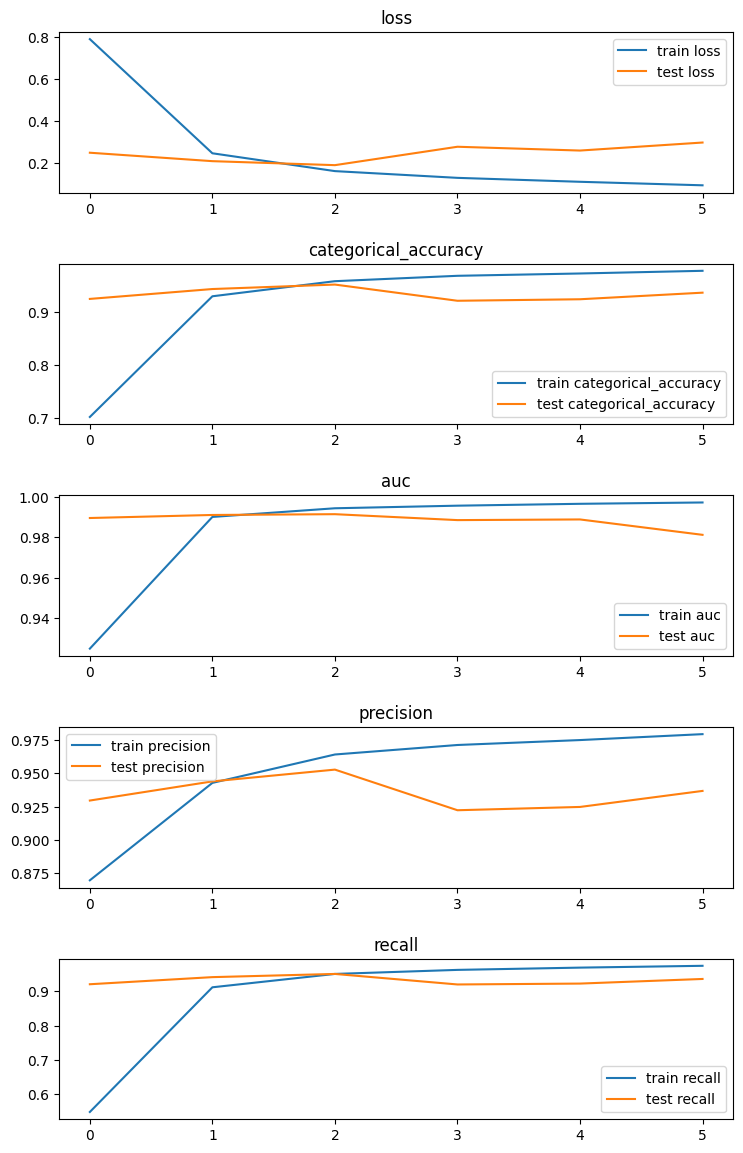

In [32]:
model.plot_history()

63/63 [==============================] - 0s 6ms/step
Confusion matrix, without normalization
[[  22    0    0    0    0]
 [  33 1775   16   24   81]
 [   0    0   16    0    0]
 [   0    2    0   17    0]
 [   0    2    1    0    6]]


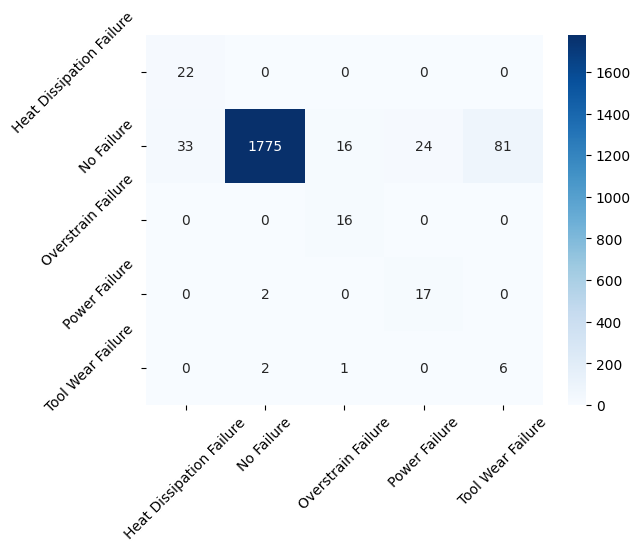

In [33]:
y_pred_val = model.predict(X_val.to_numpy())
model.plot_confusion_matrix(y_val.to_numpy().argmax(axis=1), y_pred_val.argmax(axis=1), name_target_col)

In [13]:
res = model.print_evaluation(X_val.to_numpy(), y_val.to_numpy(), y_pred_val>0.5)


242/242 - 6s - loss: 0.2018 - categorical_accuracy: 0.9401 - auc: 0.9909 - precision: 0.9427 - recall: 0.9348 - 6s/epoch - 23ms/step
loss :  0.2018272578716278
categorical_accuracy :  0.9401166439056396
auc :  0.9908520579338074
precision :  0.9427450895309448
recall :  0.9348023533821106
kappa:  0.923527021535961
F1_score:  0.9756059624108879


### Training multiple model

In [34]:
score = {}

for i in range(4,8,1):

    keras.backend.clear_session()
    
    model = modelMaintenance(
        num_layers=i, 
        num_input=num_features, 
        num_output=num_target,
        loss=CategoricalCrossentropy(),
        optimizer='adam',#Adam(5e-4),
        metrics=[CategoricalAccuracy(), AUC(),  Precision(), Recall()])
    
    model.train(X_train.to_numpy(), y_train.to_numpy(), X_test.to_numpy(), y_test.to_numpy(), batch_size=256, epochs=100, verbose=0)

    y_pred_val = model.predict(X_val.to_numpy())

    print('Nombre de couches : ', i)
    score[i] = model.print_evaluation(X_val.to_numpy(), y_val.to_numpy(), y_pred_val>0.5)
    print('')

    

c:\Users\yanni\anaconda3\envs\Predictive_maintenance_project\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 1s 14ms/step
Nombre de couches :  4
63/63 - 4s - loss: 0.3225 - categorical_accuracy: 0.9028 - auc: 0.9877 - precision: 0.9035 - recall: 0.9008 - 4s/epoch - 67ms/step
loss :  0.3225271701812744
categorical_accuracy :  0.9027568697929382
auc :  0.9877376556396484
precision :  0.9034690856933594
recall :  0.9007518887519836
kappa:  0.8776815957847196
F1_score:  0.9609022556390977



c:\Users\yanni\anaconda3\envs\Predictive_maintenance_project\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 0s 6ms/step
Nombre de couches :  5
63/63 - 2s - loss: 0.2509 - categorical_accuracy: 0.9198 - auc: 0.9925 - precision: 0.9221 - recall: 0.9198 - 2s/epoch - 24ms/step
loss :  0.25094884634017944
categorical_accuracy :  0.9197995066642761
auc :  0.9924583435058594
precision :  0.9221105575561523
recall :  0.9197995066642761
kappa:  0.9012229539040452
F1_score:  0.968421052631579



c:\Users\yanni\anaconda3\envs\Predictive_maintenance_project\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 0s 7ms/step
Nombre de couches :  6
63/63 - 2s - loss: 0.2927 - categorical_accuracy: 0.9153 - auc: 0.9877 - precision: 0.9174 - recall: 0.9128 - 2s/epoch - 25ms/step
loss :  0.29267528653144836
categorical_accuracy :  0.9152882099151611
auc :  0.9877178072929382
precision :  0.9173803329467773
recall :  0.9127819538116455
kappa:  0.8939108600125549
F1_score:  0.9661152882205514



c:\Users\yanni\anaconda3\envs\Predictive_maintenance_project\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 1s 8ms/step
Nombre de couches :  7
63/63 - 2s - loss: 0.2018 - categorical_accuracy: 0.9368 - auc: 0.9938 - precision: 0.9382 - recall: 0.9353 - 2s/epoch - 29ms/step
loss :  0.20176371932029724
categorical_accuracy :  0.9368420839309692
auc :  0.9937617182731628
precision :  0.9381598830223083
recall :  0.9353383183479309
kappa:  0.9209634926608957
F1_score:  0.9747368421052631



In [35]:
print(score)

{4: 0.9207542421311, 5: 0.9360619950444217, 6: 0.9311060747415789, 7: 0.9489086118865839}
